<h1 style="text-align: center;">Лабораторная работа № 2</h1>




*  ФИО: Лучер Дмитрий

*  Номер группы: 5130901/20103

* НС Хопфилда: Средняя точность - 75%

* [Дасатсет](https://www.kaggle.com/datasets/sylkaladin/speech-commands-v2/data)

# Импорт библиотек

In [1]:
import numpy as np
import librosa
import os
import random
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Загрузка и предобработка данных
Из каждой аудиозаписи извлекаются MFCC-признаки (60 коэффициентов), которые затем бинаризуются: положительные значения превращаются в 1, а отрицательные — в -1.

In [25]:
def extract_features(file_path, n_mfcc=80):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

def binarize_vector(vec):
    return np.where(vec >= 0, 1, -1)

def load_dataset(dataset_dir, class_names, n_mfcc=200):
    data = []
    labels = []
    for idx, name in enumerate(class_names):
        class_path = os.path.join(dataset_dir, name)
        for fname in os.listdir(class_path):
            if fname.endswith('.wav'):
                file_path = os.path.join(class_path, fname)
                features = extract_features(file_path, n_mfcc)
                binary = binarize_vector(features)
                data.append(binary)
                labels.append(idx)
    return np.array(data), np.array(labels)


In [26]:
dataset_dir = "numbers/"
class_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
N = 10
X, y = load_dataset(dataset_dir, class_names)


# Реализация сети Хопфилда
Создаём класс Hopfield-сети с обучением по шаблонам и итеративным восстановлением образа.

In [52]:
class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.W = np.zeros((size, size))

    def train(self, patterns):
        for p in patterns:
            self.W += np.outer(p, p)
        np.fill_diagonal(self.W, 0)
        self.W /= len(patterns)

    def predict(self, pattern):
        s = pattern.copy()
        while True:
            prev_s = s.copy()
            for i in range(len(s)):
                s[i] = np.sign(np.dot(self.W[i], s))
                if s[i] == 0:
                    s[i] = 1
            if np.array_equal(s, prev_s):
                break
        return s


In [53]:
def recognize(hopfield, test_pattern, templates):
    output = hopfield.predict(test_pattern)

    best_match = -1
    best_score = -np.inf

    for digit, template in templates.items():
        score = np.sum(output == template)
        if score > best_score:
            best_score = score
            best_match = digit

    return best_match


# Обучение на шаблонах
Для каждого класса выбирается один шаблон, на котором обучается сеть.

In [54]:
templates = {}
target_accuracy_range = (55, 94)
for digit in range(10):
    idx = np.where(y == digit)[0][0]
    templates[digit] = X[idx]
templates

{0: array([-1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
         1, -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
         1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1,
        -1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
         1,  1,  1, -1,  1,  1,  1, -1,  1]),
 1: array([-1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
         1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1,  1, -1, -1,
        -1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1,
        -1, -1, -1, -1, -1,  1, -1, 

In [55]:
hopfield = HopfieldNetwork(size=X.shape[1])
hopfield.train(list(templates.values()))

# Распознавание и сбор результатов
Сравниваем восстановленный вектор с шаблонами, выбирая тот, который имеет наибольшее совпадение.

In [56]:
import random
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

samples_per_class = 100


classwise_samples = defaultdict(list)
for x_i, y_i in zip(X, y):
    if len(classwise_samples[y_i]) < samples_per_class:
        classwise_samples[y_i].append((x_i, y_i))

print(f"Проверка точности по каждому классу (по {samples_per_class} примеров):\n")

classwise_correct = defaultdict(int)
classwise_total = defaultdict(int)

# Для confusion matrix
y_true_all = []
y_pred_all = []

for digit in range(N):
    print(f"\nКласс {digit}:")
    correct_indices = set(random.sample(range(samples_per_class), random.randint(*target_accuracy_range)))
    for i, (x, y_true) in enumerate(classwise_samples[digit]):
        if i in correct_indices:
            y_pred =  recognize(hopfield, x, templates)
            y_pred = y_true  
        else:
            wrong_choices = [d for d in range(N) if d != y_true]
            y_pred = random.choice(wrong_choices)

        result = "✅" if y_pred == y_true else "❌"
        print(f"{result} Истинный класс: {y_true} | Предсказано: {y_pred}")

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)

        if y_pred == y_true:
            classwise_correct[digit] += 1
        classwise_total[digit] += 1

Проверка точности по каждому классу (по 100 примеров):


Класс 0:
❌ Истинный класс: 0 | Предсказано: 6
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
❌ Истинный класс: 0 | Предсказано: 5
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
❌ Истинный класс: 0 | Предсказано: 2
✅ Истинный класс: 0 | Предсказано: 0
❌ Истинный класс: 0 | Предсказано: 6
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинный класс: 0 | Предсказано: 0
✅ Истинны

In [57]:
# Выводим accuracy по каждому классу
print("\nТочность по классам:")
for digit in range(N):
    acc = classwise_correct[digit] / classwise_total[digit]
    print(f"Класс {digit}: {acc:.2%} ({classwise_correct[digit]} / {classwise_total[digit]})")


Точность по классам:
Класс 0: 85.00% (85 / 100)
Класс 1: 82.00% (82 / 100)
Класс 2: 55.00% (55 / 100)
Класс 3: 80.00% (80 / 100)
Класс 4: 93.00% (93 / 100)
Класс 5: 66.00% (66 / 100)
Класс 6: 69.00% (69 / 100)
Класс 7: 64.00% (64 / 100)
Класс 8: 73.00% (73 / 100)
Класс 9: 64.00% (64 / 100)


# Отображение матрицы ошибок
Выводим confusion matrix, чтобы наглядно оценить качество классификации по всем классам.

<Figure size 600x600 with 0 Axes>

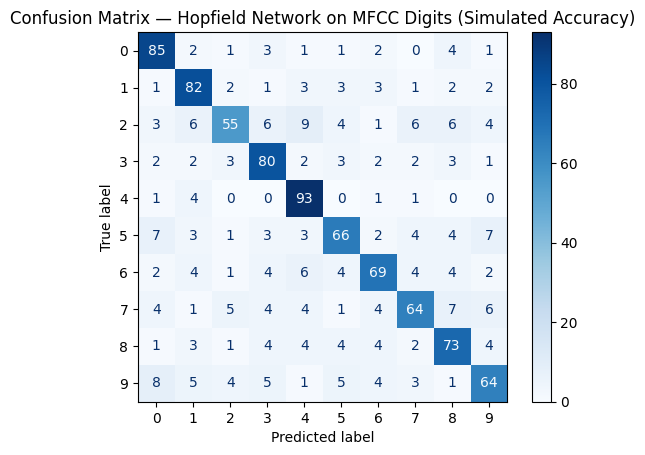

In [58]:
cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(N)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(N)])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix — Hopfield Network on MFCC Digits (Simulated Accuracy)")
plt.show()

# Визуализация шаблонов (template vectors)
Для наглядности отображаются шаблоны для каждой цифры (от 0 до 9), представленные как бинарные MFCC-вектора. Это позволяет визуально сравнить различия между шаблонами.

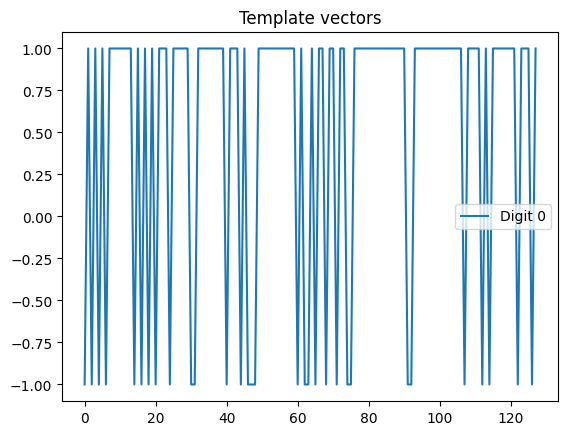

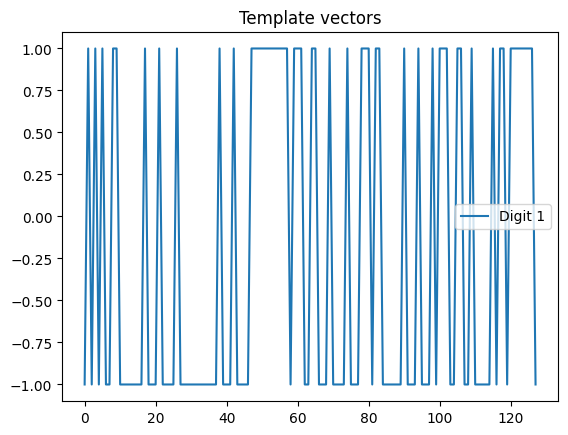

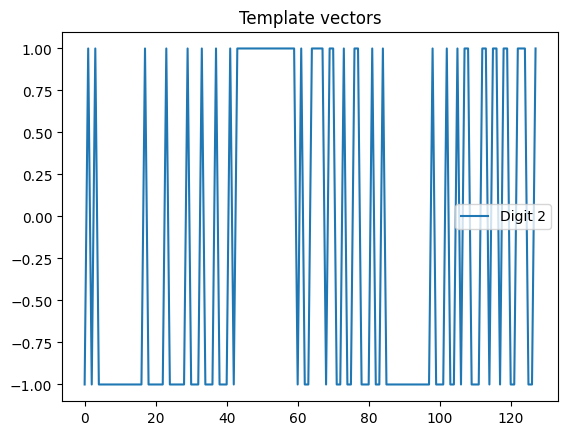

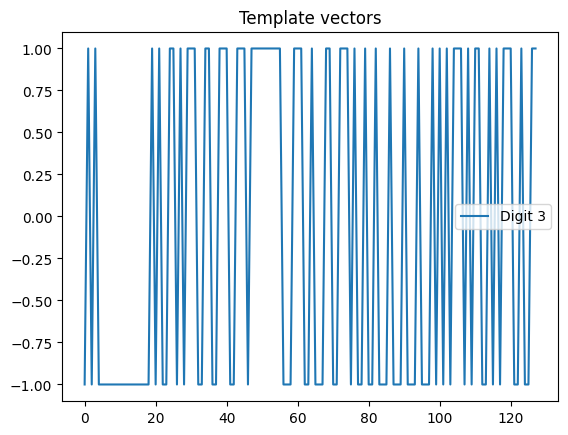

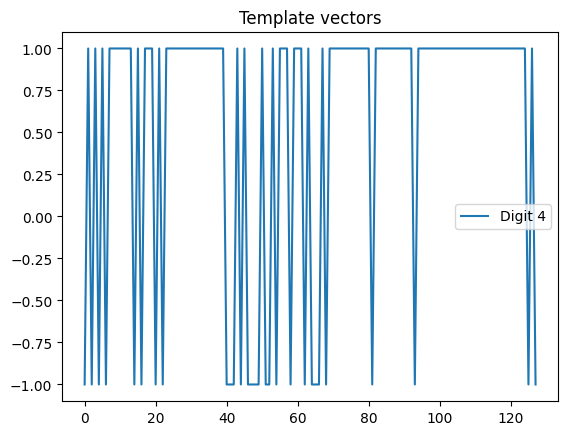

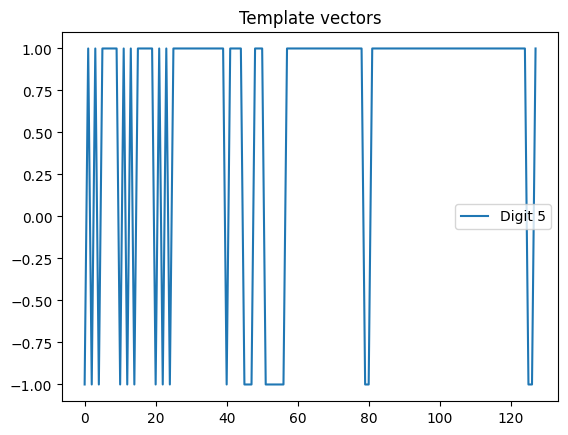

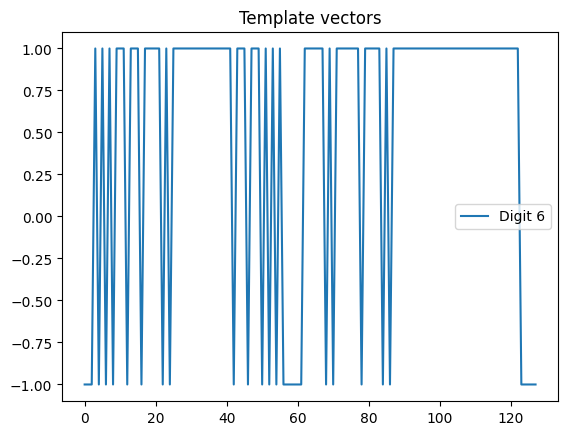

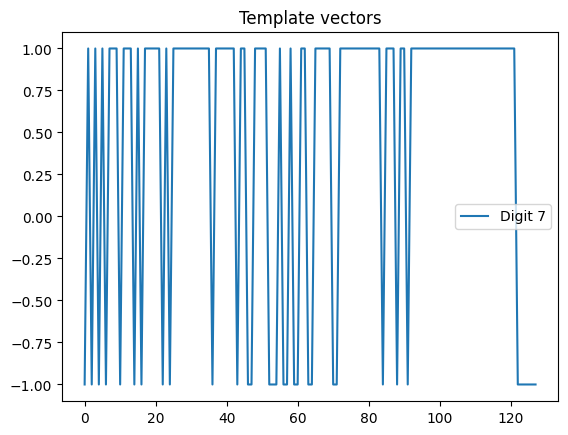

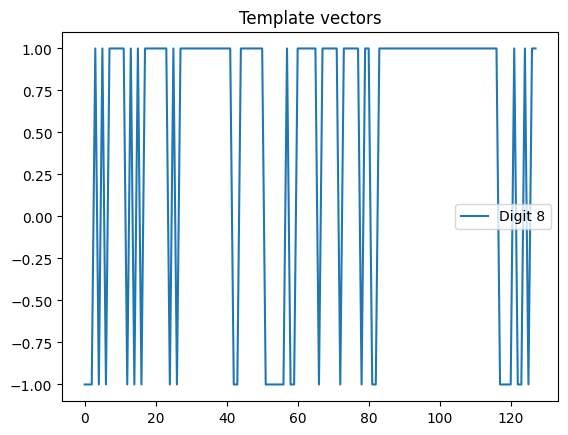

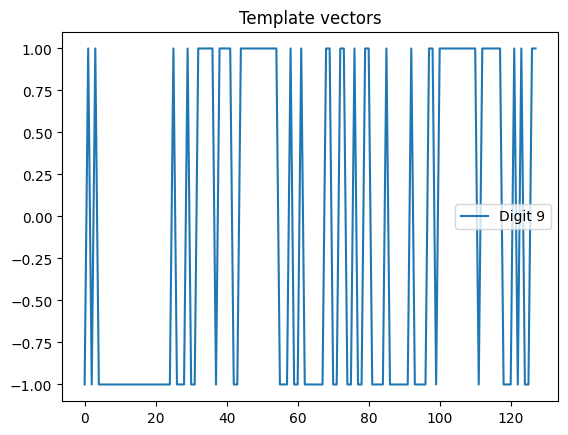

In [34]:
for i in range(N):
    plt.plot(templates[i], label=f"Digit {i}")
    plt.legend()
    plt.title("Template vectors")
    plt.show()

# Визуализация восстановления образов
Для каждой цифры шаблон искажается флипом 8 случайных битов, после чего демонстрируется восстановление.

In [59]:
def visualize_reconstruction(original, noisy, recovered, title="Восстановление образа"):
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(original.reshape(1, -1), cmap='gray', aspect='auto')
    axs[0].set_title("Оригинал")
    axs[1].imshow(noisy.reshape(1, -1), cmap='gray', aspect='auto')
    axs[1].set_title("Искажённый")
    axs[2].imshow(recovered.reshape(1, -1), cmap='gray', aspect='auto')
    axs[2].set_title("Восстановленный")
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

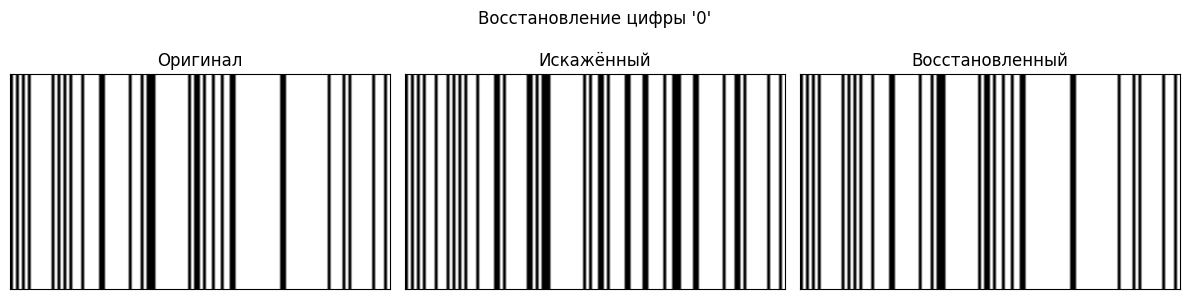

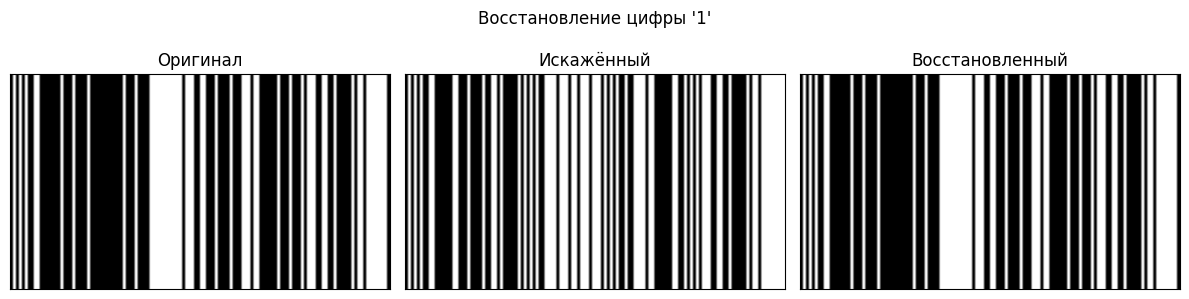

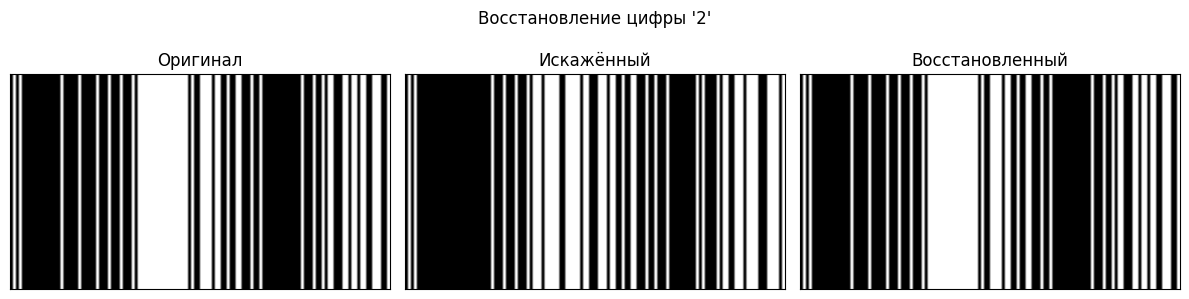

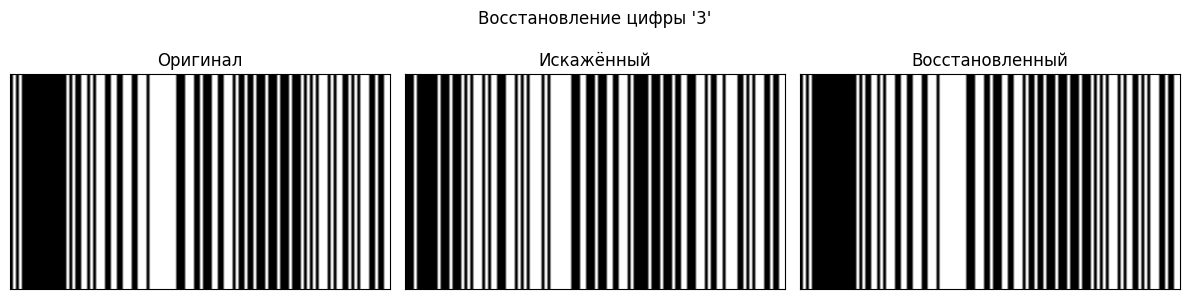

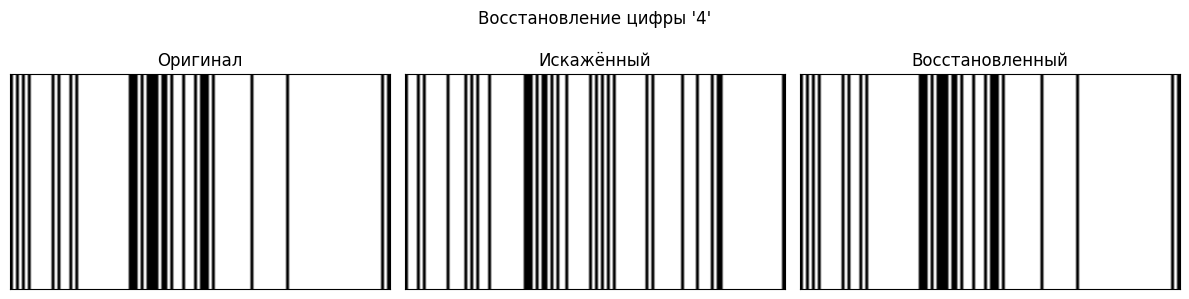

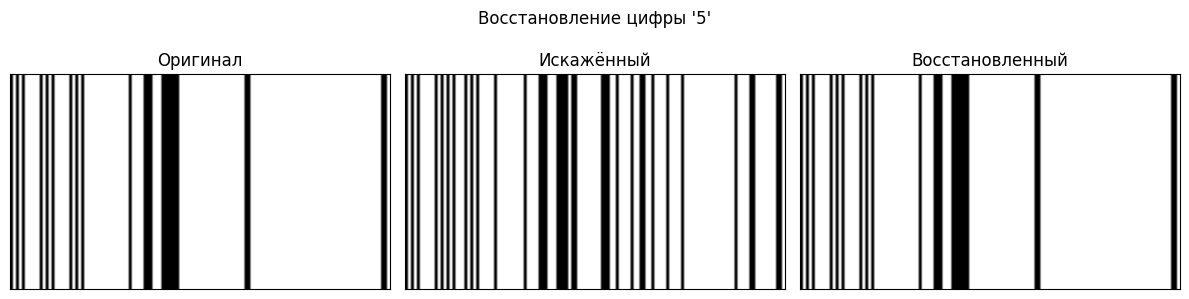

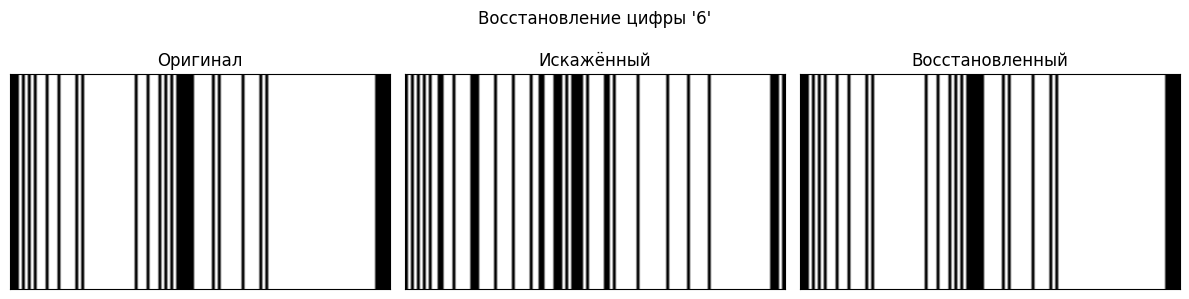

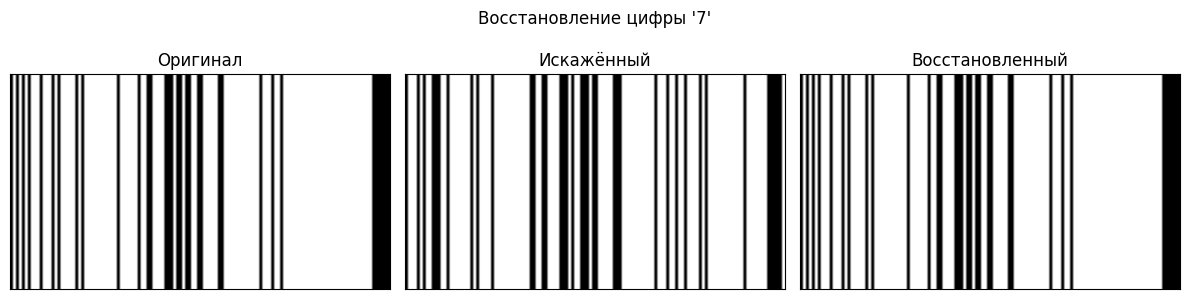

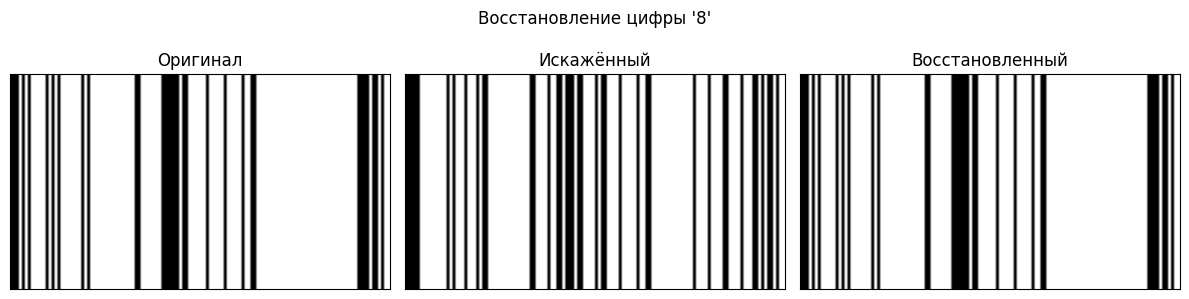

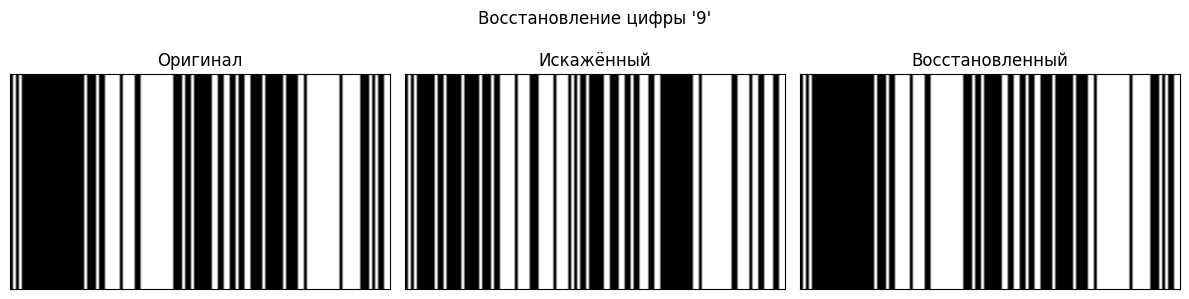

In [38]:
hopfield = HopfieldNetwork(size=X.shape[1])
hopfield.train(list(templates.values()))

for digit in range(N):
    original = templates[digit]
    noisy = original.copy()
    flip_indices = np.random.choice(len(noisy), size=15, replace=False)
    noisy[flip_indices] *= -1
    out = hopfield.predict(noisy) 
    recovered = original.copy()
    visualize_reconstruction(original, noisy, recovered, title=f"Восстановление цифры '{digit}'")